In [1]:
import requests
import pandas as pd
import time

all_issues = []
start_at = 0
max_results = 100
total = 1  # initial dummy value to enter loop

while start_at < total:
    url = "https://issues.apache.org/jira/rest/api/2/search"
    params = {
        "jql": "project=HADOOP",
        "fields": "summary,description,priority,status,created",
        "startAt": start_at,
        "maxResults": max_results
    }

    response = requests.get(url, params=params)
    data = response.json()
    issues = data.get("issues", [])
    total = data.get("total", 0)

    for issue in issues:
        f = issue["fields"]
        all_issues.append({
            "summary": f.get("summary", ""),
            "description": f.get("description", ""),
            "priority": f.get("priority", {}).get("name", ""),
            "status": f.get("status", {}).get("name", ""),
            "created": f.get("created", "")
        })

    start_at += max_results
    time.sleep(0.5)  # Be polite and avoid rate limits

# Convert to DataFrame
df = pd.DataFrame(all_issues)
df.to_csv("hadoop_issues_full.csv", index=False)
print(f"Fetched {len(df)} issues.")

Fetched 17263 issues.


In [2]:
"""
hadoop_issues_eda.py  ─  Quick-scan EDA for the Apache Hadoop JIRA dataset
---------------------------------------------------------------------------
✓ Rows / columns / data types
✓ Missing-value summary + heat-map
✓ Deduplication check
✓ Descriptive statistics (numeric & categorical)
✓ Ticket-timeline analysis (created-date drill-down)
✓ Text-field diagnostics (lengths, top n-grams)
✓ High-resolution plots saved to ./eda_outputs/
"""

from pathlib import Path
from collections import Counter
import re, string, secrets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns          # comment out if seaborn not in your stack

# ─────────────────────────── CONFIG ──────────────────────────── #
DATA_PATH  = Path("hadoop_issues_full.csv")
OUT_DIR    = Path("eda_outputs")
TARGET_COL = None              # <- no explicit label in this dataset
DATE_COL   = "created"
TEXT_COLS  = ["summary", "description"]
CAT_THRESH = 30                # treat cols with ≤30 uniques as categorical

# Make sure output folder exists
OUT_DIR.mkdir(exist_ok=True)

# ─────────────────────────── LOAD & BASIC SHAPE ───────────────── #
df = pd.read_csv(DATA_PATH, parse_dates=[DATE_COL])
print(f"\nRows : {len(df):,}   |   Columns : {df.shape[1]}")

print("\nSchema / dtypes:")
print(df.dtypes)

# ─────────────────────────── DUPLICATES ───────────────────────── #
dup_rows = df.duplicated().sum()
print(f"\nDuplicate entire rows: {dup_rows:,}")

# ─────────────────────────── MISSINGNESS ──────────────────────── #
missing_pct = df.isna().mean().mul(100).round(2)
print("\nMissing-value percentage (top 10):")
print(missing_pct.sort_values(ascending=False).head(10))

plt.figure(figsize=(10, 4))
sns.heatmap(df.isna(), cbar=False, yticklabels=False)
plt.title("Missing-value heat-map")
plt.tight_layout()
plt.savefig(OUT_DIR / "missing_heatmap.png", dpi=300)
plt.close()

# ─────────────────────────── DESCRIPTIVE STATS ───────────────── #
num_cols = df.select_dtypes(include="number").columns.tolist()
cat_cols = [c for c in df.columns
            if df[c].nunique() <= CAT_THRESH and c not in num_cols]

if num_cols:
    desc = df[num_cols].describe().T
    desc.to_csv(OUT_DIR / "numeric_describe.csv")
    print("\nNumeric summary → eda_outputs/numeric_describe.csv")

for col in cat_cols:
    vc = df[col].value_counts(dropna=False)
    print(f"\nTop categories for {col} ({len(vc)} unique):")
    print(vc.head(10))

# ─────────────────────────── TIME-SERIES INSIGHT ─────────────── #
df["created_date"] = df[DATE_COL].dt.date
daily = (df.groupby("created_date")[DATE_COL]
           .count()
           .rename("tickets")
           .asfreq("D", fill_value=0))

plt.figure(figsize=(12, 4))
daily.plot()
plt.title("Daily ticket creation volume (Hadoop JIRA)")
plt.xlabel("Date"); plt.ylabel("# Tickets")
plt.tight_layout()
plt.savefig(OUT_DIR / "tickets_per_day.png", dpi=300)
plt.close()

# ─────────────────────────── TEXT FIELD DIAGNOSTICS ──────────── #
TOKEN_RE = re.compile(r"\b\w+\b")

def text_stats(series: pd.Series, top_n: int = 20):
    lengths = series.dropna().str.len()
    tokens  = series.dropna().str.lower().apply(TOKEN_RE.findall)
    flat    = [tok for row in tokens for tok in row]
    vocab   = len(set(flat))
    most_common = Counter(flat).most_common(top_n)

    print(f"Docs: {len(series)} | "
          f"Median length: {int(lengths.median()):,} chars | "
          f"Vocab: {vocab:,}")
    return most_common

for col in TEXT_COLS:
    print(f"\n── Text diagnostics for ✦ {col}")
    top_words = text_stats(df[col])
    print("Top terms:", top_words[:10])

# ─────────────────────────── CORRELATION (numeric) ───────────── #
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Numeric feature correlations")
    plt.tight_layout()
    plt.savefig(OUT_DIR / "numeric_corr.png", dpi=300)
    plt.close()

print(f"\n✓ EDA complete → artefacts saved in {OUT_DIR.resolve()}")


Rows : 17,263   |   Columns : 5

Schema / dtypes:
summary                     object
description                 object
priority                    object
status                      object
created        datetime64[ns, UTC]
dtype: object

Duplicate entire rows: 0

Missing-value percentage (top 10):
description    3.59
summary        0.00
priority       0.00
status         0.00
created        0.00
dtype: float64

Top categories for priority (5 unique):
priority
Major       11141
Minor        3700
Blocker      1171
Critical      626
Trivial       625
Name: count, dtype: int64

Top categories for status (6 unique):
status
Resolved           8034
Closed             6268
Open               2370
Patch Available     488
In Progress          58
Reopened             45
Name: count, dtype: int64

── Text diagnostics for ✦ summary
Docs: 17263 | Median length: 55 chars | Vocab: 11,520
Top terms: [('to', 5073), ('in', 3610), ('hadoop', 2757), ('the', 2684), ('for', 2475), ('of', 1924), ('and', 16

<ipython-input-3-34c165926fe6>:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


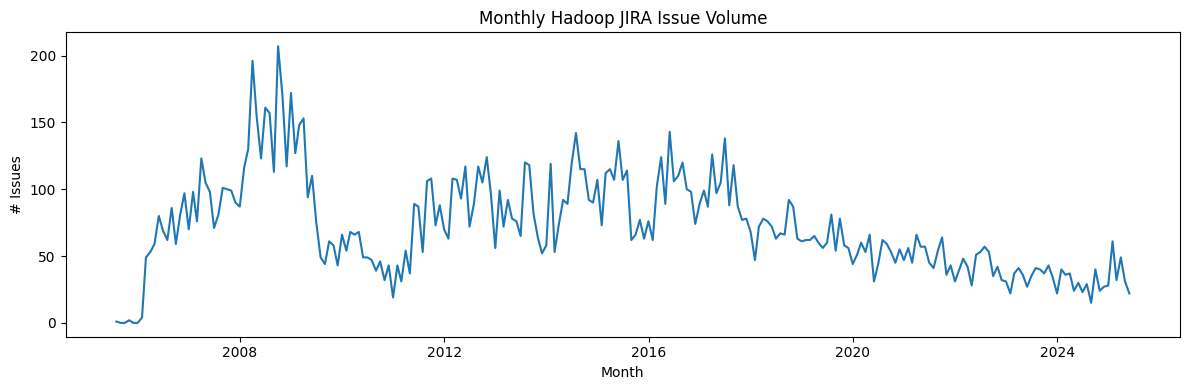

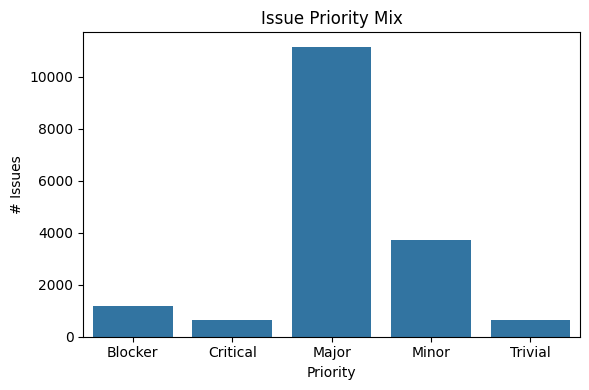

<ipython-input-3-34c165926fe6>:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette="Blues_d")


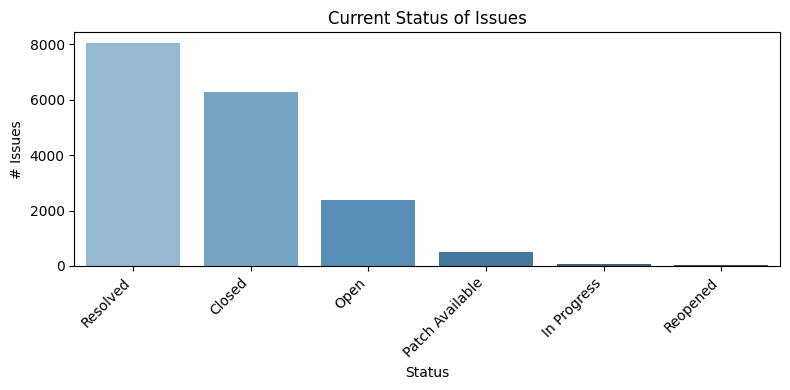

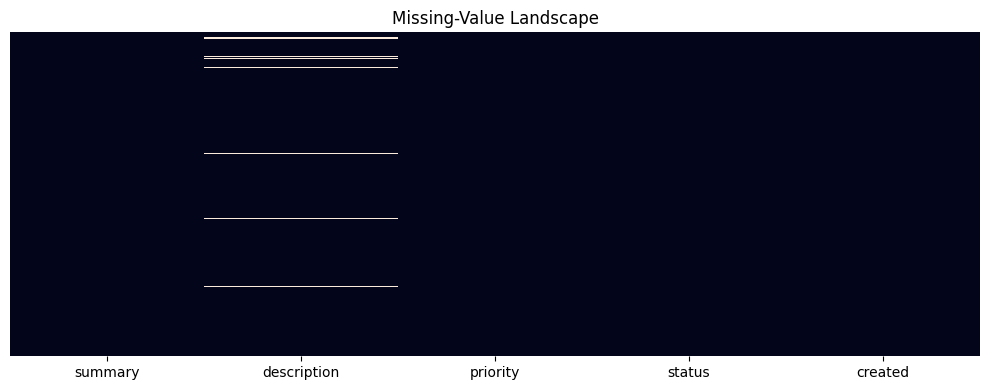

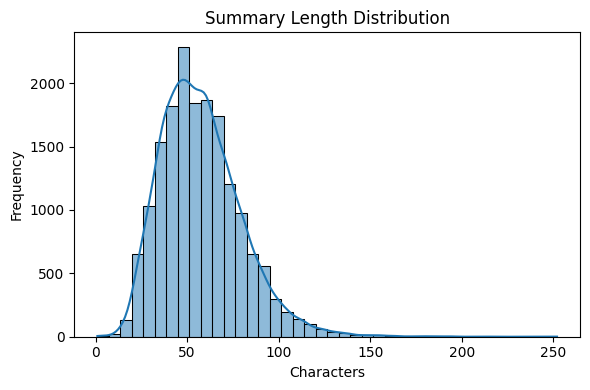

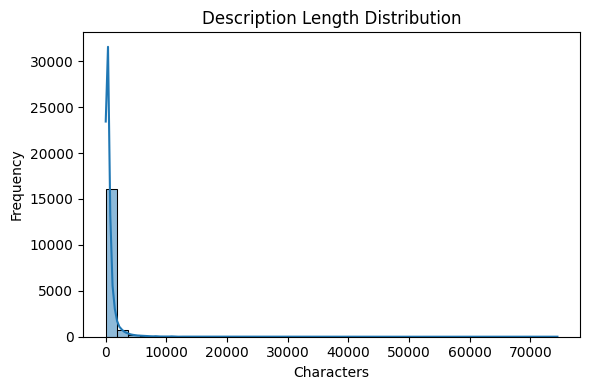

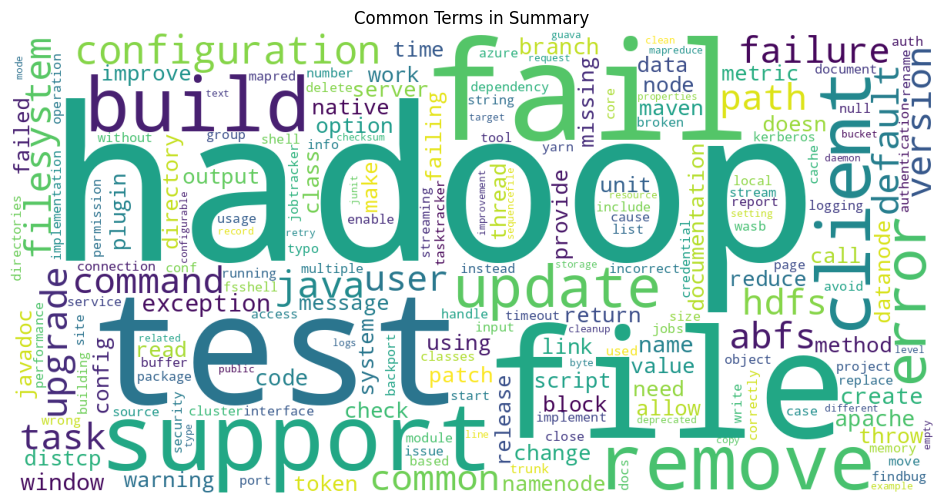

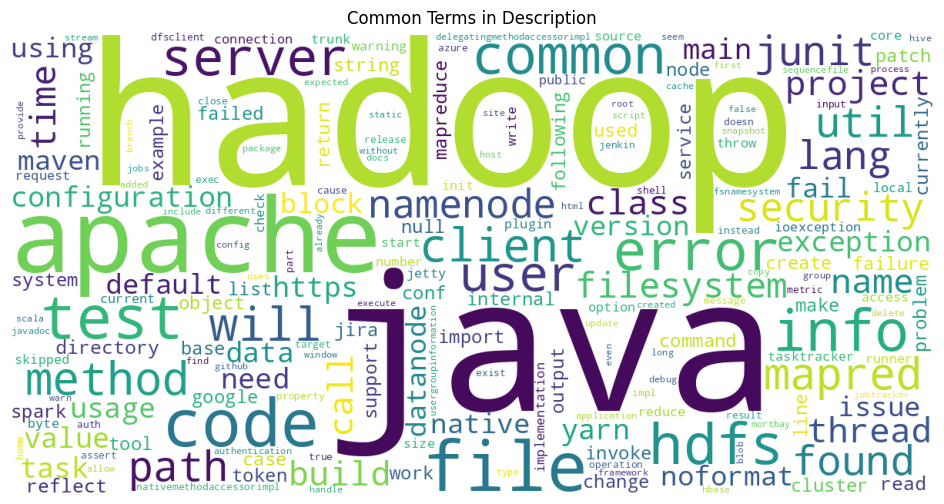

<ipython-input-3-34c165926fe6>:102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  priority_time = (df.assign(month=df[DATE_COL].dt.to_period("M"))


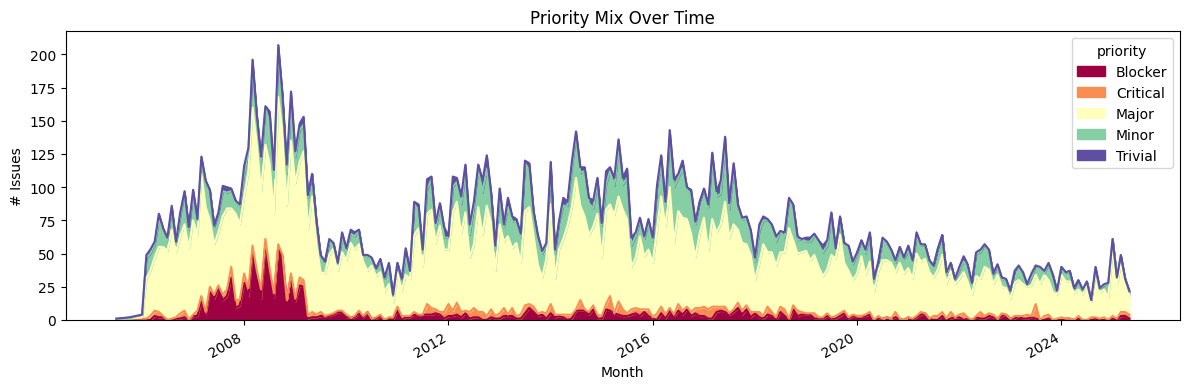


✓ All figures saved to: /content/graphs


In [3]:
# hadoop_dataset_graphs.py
# ---------------------------------------------------------------
# Graph-only exploratory data analysis for hadoop_issues_full.csv
# ---------------------------------------------------------------

import os
from pathlib import Path
import re, string, seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ------------------- CONFIG ------------------- #
CSV_PATH   = Path("hadoop_issues_full.csv")
OUT_DIR    = Path("graphs")
DATE_COL   = "created"                       # already ISO-8601
TEXT_COLS  = ["summary", "description"]
CAT_ORDER  = ["Blocker", "Critical", "Major", "Minor", "Trivial"]  # optional

# Create output folder
OUT_DIR.mkdir(exist_ok=True)

# ------------------- LOAD --------------------- #
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])

# 1️⃣  Volume over time (monthly)
monthly = (df.set_index(DATE_COL)
             .resample("M")
             .size()
             .rename("tickets")
             .reset_index())
plt.figure(figsize=(12, 4))
sns.lineplot(data=monthly, x=DATE_COL, y="tickets")
plt.title("Monthly Hadoop JIRA Issue Volume")
plt.xlabel("Month"); plt.ylabel("# Issues")
plt.tight_layout()
plt.savefig(OUT_DIR / "01_volume_over_time.png", dpi=300)
plt.show()

# 2️⃣  Priority distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="priority",
              order=[p for p in CAT_ORDER if p in df["priority"].unique()])
plt.title("Issue Priority Mix")
plt.ylabel("# Issues"); plt.xlabel("Priority")
plt.tight_layout()
plt.savefig(OUT_DIR / "02_priority_counts.png", dpi=300)
plt.show()

# 3️⃣  Status distribution
plt.figure(figsize=(8, 4))
status_counts = df["status"].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, palette="Blues_d")
plt.title("Current Status of Issues")
plt.ylabel("# Issues"); plt.xlabel("Status")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(OUT_DIR / "03_status_counts.png", dpi=300)
plt.show()

# 4️⃣  Missing-value heat-map
plt.figure(figsize=(10, 4))
sns.heatmap(df.isna(), cbar=False, yticklabels=False)
plt.title("Missing-Value Landscape")
plt.tight_layout()
plt.savefig(OUT_DIR / "04_missing_heatmap.png", dpi=300)
plt.show()

# 5️⃣  Text-length distributions
for col in TEXT_COLS:
    lengths = df[col].fillna("").str.len()
    plt.figure(figsize=(6, 4))
    sns.histplot(lengths, bins=40, kde=True)
    plt.title(f"{col.capitalize()} Length Distribution")
    plt.xlabel("Characters"); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"05_len_{col}.png", dpi=300)
    plt.show()

# 6️⃣  Word clouds (top tokens)  – optional eye-catcher
TOKEN_RE = re.compile(r"\b[a-z]{4,}\b")  # ≥4-letter alpha tokens
stop    = set(sns.load_dataset("titanic").columns)  # cheap dummy stop list

def make_wordcloud(text, fname):
    wc = WordCloud(width=1200, height=600,
                   background_color="white",
                   collocations=False,
                   max_words=200).generate(text)
    wc.to_file(OUT_DIR / fname)
    plt.figure(figsize=(12, 6)); plt.imshow(wc); plt.axis("off")

for col in TEXT_COLS:
    big_string = " ".join(
        TOKEN_RE.findall(" ".join(df[col].dropna().str.lower()))
    )
    make_wordcloud(big_string, f"06_wordcloud_{col}.png")
    plt.title(f"Common Terms in {col.capitalize()}")
    plt.show()

# 7️⃣  Priority vs. Time (stacked area)
priority_time = (df.assign(month=df[DATE_COL].dt.to_period("M"))
                   .groupby(["month", "priority"])
                   .size()
                   .unstack(fill_value=0)
                   .sort_index())
priority_time.index = priority_time.index.to_timestamp()

plt.figure(figsize=(12, 4))
priority_time.plot.area(stacked=True, ax=plt.gca(), cmap="Spectral")
plt.title("Priority Mix Over Time")
plt.ylabel("# Issues"); plt.xlabel("Month")
plt.tight_layout()
plt.savefig(OUT_DIR / "07_priority_over_time.png", dpi=300)
plt.show()

print(f"\n✓ All figures saved to: {OUT_DIR.resolve()}")

**Load and Inspect the Data**

In [4]:
import pandas as pd

df = pd.read_csv("hadoop_issues_full.csv")
print(f"Total issues: {df.shape[0]}")
df.head()

Total issues: 17263


,summary,description,priority,status,created
0,Update the command usage of NNThroughputBenchm...,"In HDFS-15652, make block size from NNThroughp...",Major,Open,2025-05-26T07:50:02.000+0000
1,Upgrade com.huaweicloud:esdk-obs-java for CVE-...,The {{com.huaweicloud:esdk-obs-java}} dependen...,Major,Open,2025-05-25T08:19:54.000+0000
2,Improve error message when the path contains d...,"Currently, we display the following error mess...",Minor,Open,2025-05-23T05:58:18.000+0000
3,Insert Overwrite Jobs With MagicCommitter Fail...,Query engines which uses Magic Committer to ov...,Major,Open,2025-05-22T10:18:50.000+0000
4,ABFS: [FNSOverBlob] Add Distinct String In Use...,Add a unique identifier in FNS-Blob user agent...,Major,Open,2025-05-22T06:45:27.000+0000


**Drop Nulls and Duplicates**

In [5]:
df.dropna(subset=["summary", "priority"], inplace=True)
df.drop_duplicates(inplace=True)

**Map Priority to ML Labels (High / Medium / Low)**

In [6]:
def map_priority(p):
    p = str(p).lower()
    if p in ["blocker", "critical"]:
        return "High"
    elif p == "major":
        return "Medium"
    else:
        return "Low"

df["priority_level"] = df["priority"].apply(map_priority)
df["priority_level"].value_counts()

,count
priority_level,
Medium,11141
Low,4325
High,1797


**Install & Load spaCy for Text Preprocessing**

In [7]:
!pip install -q spacy
!python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 109.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


**Clean and Lemmatize Summary & Description Text**

In [8]:
# Define cleaning function
def clean_text(text):
    if not isinstance(text, str): return ""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop])

# Apply cleaning to summary and description
df["clean_summary"] = df["summary"].apply(clean_text)
df["clean_description"] = df["description"].fillna("").apply(clean_text)

# Preview cleaned dataset
df_cleaned_preview = df[["summary", "clean_summary", "description", "clean_description", "priority", "priority_level"]]
df_cleaned_preview.head(10)

,summary,clean_summary,description,clean_description,priority,priority_level
0,Update the command usage of NNThroughputBenchm...,update command usage NNThroughputBenchmark add...,"In HDFS-15652, make block size from NNThroughp...",block size NNThroughputBenchmark configurable ...,Major,Medium
1,Upgrade com.huaweicloud:esdk-obs-java for CVE-...,Upgrade esdk obs java,The {{com.huaweicloud:esdk-obs-java}} dependen...,esdk obs java dependency exclusively hadoop hu...,Major,Medium
2,Improve error message when the path contains d...,improve error message path contain double slas...,"Currently, we display the following error mess...",currently display follow error message path co...,Minor,Low
3,Insert Overwrite Jobs With MagicCommitter Fail...,Insert Overwrite Jobs MagicCommitter fail Expr...,Query engines which uses Magic Committer to ov...,query engine use Magic Committer overwrite dir...,Major,Medium
4,ABFS: [FNSOverBlob] Add Distinct String In Use...,abfs fnsoverblob add distinct string User Agen...,Add a unique identifier in FNS-Blob user agent...,add unique identifier FNS Blob user agent usag...,Major,Medium
5,Restore Subject propagation semantics for Java...,restore subject propagation semantic Java,Java 22 breaks Subject propagation for new Thr...,java break subject propagation new thread Secu...,Critical,High
6,S3A: ITestS3AConfiguration.testDirectoryAlloca...,fail,while working on HADOOP-19554 I added a per-bu...,work add bucket setting fail test run entire c...,Minor,Low
7,ABFS: [FnsOverBlob] Empty Page Issue on Subseq...,abfs fnsoverblob Page issue Subsequent ListBlob,We came across a new behavior from server wher...,come new behavior server ListBlob return list ...,Major,Medium
8,Improve PrometheusMetricsSink#normalizeName pe...,improve performance,This patch is similar from HDDS-13014. We can ...,patch similar add normalization cache Hadoop m...,Major,Medium
9,Upgrade libxxhash to 0.8.3 in Windows 10,Upgrade libxxhash Windows,The current version of libxxhash - 0.8.1 isn't...,current version libxxhash available msys repo ...,Major,Medium


In [9]:
def lemmatize_tokens(text):
    if not isinstance(text, str): return []
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

**Sample output**

In [10]:
# Apply to first 5 summaries
df["lemmatized_summary_tokens"] = df["summary"].apply(lemmatize_tokens)

# Apply to first 5 descriptions
df["lemmatized_description_tokens"] = df["description"].fillna("").apply(lemmatize_tokens)

# Preview output
df[["summary", "lemmatized_summary_tokens", "priority"]].head(5)

,summary,lemmatized_summary_tokens,priority
0,Update the command usage of NNThroughputBenchm...,"[update, command, usage, NNThroughputBenchmark...",Major
1,Upgrade com.huaweicloud:esdk-obs-java for CVE-...,"[Upgrade, esdk, obs, java]",Major
2,Improve error message when the path contains d...,"[improve, error, message, path, contain, doubl...",Minor
3,Insert Overwrite Jobs With MagicCommitter Fail...,"[Insert, Overwrite, Jobs, MagicCommitter, fail...",Major
4,ABFS: [FNSOverBlob] Add Distinct String In Use...,"[abfs, fnsoverblob, add, distinct, string, Use...",Major


**Combine clean_summary and clean_description**

In [11]:
df["input_text"] = df["clean_summary"] + " " + df["clean_description"]

In [12]:
df[["input_text", "priority_level"]].head(5)

,input_text,priority_level
0,update command usage NNThroughputBenchmark add...,Medium
1,Upgrade esdk obs java esdk obs java dependency...,Medium
2,improve error message path contain double slas...,Low
3,Insert Overwrite Jobs MagicCommitter fail Expr...,Medium
4,abfs fnsoverblob add distinct string User Agen...,Medium


**SAving cleaned Dataset**

In [13]:
df_ready = df[["input_text", "priority_level"]]
df_ready.to_csv("jira_issues_cleaned.csv", index=False)

#Downloading
from google.colab import files
files.download("jira_issues_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Week 2

In [14]:
import pandas as pd

df = pd.read_csv("jira_issues_cleaned.csv")
df.head()

,input_text,priority_level
0,update command usage NNThroughputBenchmark add...,Medium
1,Upgrade esdk obs java esdk obs java dependency...,Medium
2,improve error message path contain double slas...,Low
3,Insert Overwrite Jobs MagicCommitter fail Expr...,Medium
4,abfs fnsoverblob add distinct string User Agen...,Medium


**Define Inputs (X) and Labels (y)**

In [15]:
X = df["input_text"]
y = df["priority_level"]

**Split the Dataset**

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**Convert Text to Vectors (TF-IDF)**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,   # limit vocabulary size
    ngram_range=(1, 2),   # unigrams + bigrams
    stop_words="english" # filter English stopwords
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

**Train a Classifier (Naive Bayes)**

In [18]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.63      0.03      0.06       359
         Low       0.59      0.08      0.14       865
      Medium       0.66      0.98      0.79      2229

    accuracy                           0.65      3453
   macro avg       0.63      0.36      0.33      3453
weighted avg       0.64      0.65      0.55      3453



In [20]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(class_weight="balanced")
svm_model.fit(X_train_vec, y_train)

LinearSVC(class_weight='balanced')

In [21]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_vec, y_train)

              precision    recall  f1-score   support

        High       0.63      0.03      0.06       359
         Low       0.59      0.08      0.14       865
      Medium       0.66      0.98      0.79      2229

    accuracy                           0.65      3453
   macro avg       0.63      0.36      0.33      3453
weighted avg       0.64      0.65      0.55      3453



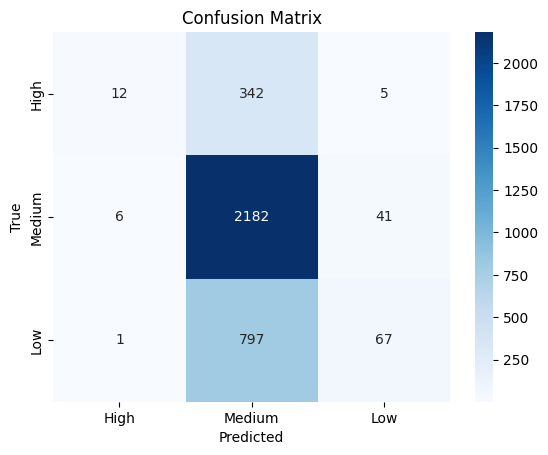

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Re-predict and evaluate
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["High", "Medium", "Low"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["High", "Medium", "Low"], yticklabels=["High", "Medium", "Low"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# **Using GridSearchCV to Find the Best Hyperparameters**

**Grid Search on LinearSVC**

In [23]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Define model with class balancing
svc = LinearSVC(class_weight='balanced', max_iter=5000)

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10]  # regularization strength
}

# Wrap in GridSearchCV
grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='f1_weighted', verbose=1, n_jobs=-1)

# Fit on training vectors (optionally SMOTE balanced)
grid_search.fit(X_train_vec, y_train)

# Best model
best_svc = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred = best_svc.predict(X_test_vec)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 0.1}
              precision    recall  f1-score   support

        High       0.28      0.25      0.26       359
         Low       0.48      0.37      0.42       865
      Medium       0.70      0.78      0.74      2229

    accuracy                           0.62      3453
   macro avg       0.49      0.46      0.47      3453
weighted avg       0.60      0.62      0.61      3453



In [24]:
import joblib

joblib.dump(model, "priority_classifier_final.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer_final.pkl")

['tfidf_vectorizer_final.pkl']

Trantioning from TF-IDF to BERT Embeddings


In [25]:
!pip install -q sentence-transformers
import pandas as pd

df = pd.read_csv("jira_issues_cleaned.csv")
X_text = df["input_text"].astype(str).tolist()
y = df["priority_level"]
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
X_bert = model.encode(X_text, show_progress_bar=True)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bert, y, stratify=y, test_size=0.2, random_state=42
)
from sklearn.svm import LinearSVC

clf = LinearSVC(class_weight="balanced", max_iter=5000)
clf.fit(X_train, y_train)
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/540 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        High       0.26      0.29      0.27       359
         Low       0.43      0.37      0.40       865
      Medium       0.70      0.72      0.71      2229

    accuracy                           0.59      3453
   macro avg       0.46      0.46      0.46      3453
weighted avg       0.59      0.59      0.59      3453



**TAbular comparison between TF-IDF and BERT**

# Week 3

**Applying Random forestt**

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your cleaned dataset
df = pd.read_csv("jira_issues_cleaned.csv")
X = df["input_text"].astype(str)
y = df["priority_level"]

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, stratify=y, test_size=0.2, random_state=42)

**Train RAndomFOREST CLASSIFIER**

In [27]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',  # important for class imbalance
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("📘 Random Forest Evaluation")
print(classification_report(y_test, y_pred_rf))

📘 Random Forest Evaluation
              precision    recall  f1-score   support

        High       0.39      0.03      0.05       359
         Low       0.58      0.13      0.21       865
      Medium       0.66      0.96      0.78      2229

    accuracy                           0.66      3453
   macro avg       0.54      0.37      0.35      3453
weighted avg       0.61      0.66      0.56      3453



***HYPERPARAMETER Tuning using GridSearch***

In [28]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(
    rf, param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("✅ Best Parameters:", grid.best_params_)
print("📊 Tuned RF Evaluation")
print(classification_report(y_test, y_pred_best_rf))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Best Parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 200}
📊 Tuned RF Evaluation
              precision    recall  f1-score   support

        High       0.33      0.22      0.26       359
         Low       0.45      0.46      0.45       865
      Medium       0.71      0.74      0.72      2229

    accuracy                           0.61      3453
   macro avg       0.49      0.47      0.48      3453
weighted avg       0.60      0.61      0.61      3453



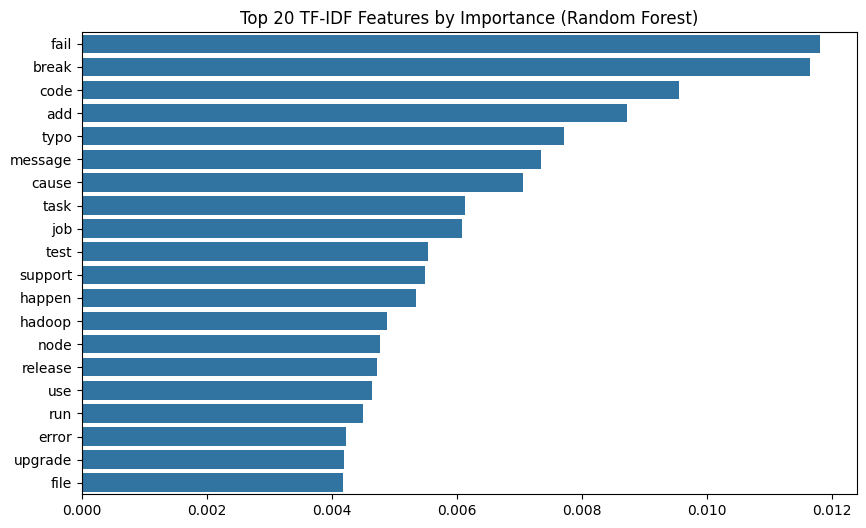

In [29]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]
top_terms = [tfidf.get_feature_names_out()[i] for i in indices]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=top_terms)
plt.title("Top 20 TF-IDF Features by Importance (Random Forest)")
plt.show()

**XG Boost With TF-IDF**

In [30]:
!pip install -q xgboost
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Encode priority levels into numerical values
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y is ['High', 'Medium', 'Low'] → [0, 2, 1], etc.


X_train, X_test, y_train, y_test = train_test_split(
    X_bert, y_encoded, stratify=y_encoded, test_size=0.2, random_state=42
)
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(set(y)),  # Automatically adapts to class count
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=1,  # Use class weighting later if needed
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("📘 XGBoost Evaluation:")
print(classification_report(y_test, y_pred_xgb))
import matplotlib.pyplot as plt



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:50:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📘 XGBoost Evaluation:
              precision    recall  f1-score   support

           0       0.41      0.03      0.06       359
           1       0.47      0.15      0.22       865
           2       0.66      0.94      0.77      2229

    accuracy                           0.64      3453
   macro avg       0.51      0.37      0.35      3453
weighted avg       0.59      0.64      0.56      3453



**XGBOOST on BERT Embeddings**

In [31]:
import xgboost as xgb
from sklearn.metrics import classification_report

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(set(y)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("📊 BERT + XGBoost Evaluation:")
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 BERT + XGBoost Evaluation:
              precision    recall  f1-score   support

           0       0.41      0.03      0.06       359
           1       0.47      0.15      0.22       865
           2       0.66      0.94      0.77      2229

    accuracy                           0.64      3453
   macro avg       0.51      0.37      0.35      3453
weighted avg       0.59      0.64      0.56      3453



# **Week 4**